<a 
href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab10.ipynb"
  target="_parent">
  <img
    src="https://colab.research.google.com/assets/colab-badge.svg"
    alt="Open In Colab"/>
</a>

# Lab 9: Transfer Learning/Fine-Tuning

## Description

### Objective

- Gain experience fine-tuning pre-trained models to domain-specific applications.

### Deliverable

For this lab you will submit an ipython notebook via learning suite. The bulk of the work is in modifying fine-tuning a pre-trained ResNet. Fine-tuning the GPT-2 language model is pretty easy. The provided code works as is; you will just have to swap in your own text dataset.

### Grading

- 35% Create a dataset class for your own dataset
- 35% Create a network class that wraps a pretrained ResNet
- 20% Implement unfreezing in the network class
- 10% Fine-tune GPT-2 on your own dataset

### Tips
- Your life will be better if you download a dataset that already has the data in the expected format for ImageFolder (make sure to read the documentation!). The datasets recommended below are in the correct format.
- Get the CNN working on the provided dataset (bird species classification) before swapping in your own.
- For reference on freezing/unfreezing network weights, see [this github gist](https://gist.github.com/jcjohnson/6e41e8512c17eae5da50aebef3378a4c)
- For training GPT-2, first try the medium-size (355M parameter) model. If your Colab instance doesn't have enough GPU space, you may need to switch to the small-size (124M parameter) model, but the results will be less impressive.

In [1]:
from torchvision.models import resnet152
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import torch
from torch import optim, nn
import zipfile
from google.colab import files
import os
import sys
from PIL import Image, ImageOps
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import pdb

## 1 Fine-tune a ResNet for image classification

### 1.1 Find a dataset to fine-tune on, and make a Dataset class (1 hr.)

#### TODO:

- Inherit from torch.utils.data.Dataset
- Use a [torchvision.datasets.ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#torchvision.datasets.ImageFolder)
- Don't spend too long finding another dataset. Some suggestions that you are free to use:
 - https://www.kaggle.com/akash2907/bird-species-classification
 - https://www.kaggle.com/jessicali9530/stanford-dogs-dataset
 - https://www.kaggle.com/puneet6060/intel-image-classification


#### Help for downloading kaggle datasets
Downloading Kaggle datasets requires authentication, so you can't just download from a url. Here are some step-by-step instructions of how to get Kaggle datasets in Colab

1. Create an API key in Kaggle
    - Click on profile photo
    - Go to 'My Account'
    - Scroll down to the API access section and click "Create New API Token"
    - `kaggle.json` is now downloaded to your computer

2. Upload the API key and install the Kaggle API client by running the next cell (run it again if it throws an error the first time). Also, `files.upload()` may not work in Firefox. One solution is to expand the Files banner (indicated by the '>' tab on the left side of the page) and use that to upload the key.

In [38]:
# # Run this cell and select the kaggle.json file downloaded
# # from the Kaggle account settings page.
# from google.colab import files
# files.upload()
# # Next, install the Kaggle API client.
# !pip install -q kaggle
# # Let's make sure the kaggle.json file is present.
# !ls -lha kaggle.json
# # The Kaggle API client expects this file to be in ~/.kaggle,
# # so move it there.
# !mkdir -p ~/.kaggle
# !mv kaggle.json ~/.kaggle/
# # This permissions change avoids a warning on Kaggle tool startup.
# !chmod 600 ~/.kaggle/kaggle.json

3. Copy the desired dataset locally

In [39]:
# Example download command for dataset found here: https://www.kaggle.com/akash2907/bird-species-classification
# !kaggle datasets download -d akash2907/bird-species-classification

In [40]:
# ! rm -R dogs
# ! rm dogs-trimmed.zip

In [41]:
![ ! -f dogs-trimmed.zip ] && wget https://deep-learning-474.s3-us-west-1.amazonaws.com/dogs-trimmed.zip
![ ! -d dogs ] && echo "unzipping dogs.zip" && unzip -q dogs-trimmed.zip -d dogs

--2020-11-09 16:59:43--  https://deep-learning-474.s3-us-west-1.amazonaws.com/dogs-trimmed.zip
Resolving deep-learning-474.s3-us-west-1.amazonaws.com (deep-learning-474.s3-us-west-1.amazonaws.com)... 52.219.116.225
Connecting to deep-learning-474.s3-us-west-1.amazonaws.com (deep-learning-474.s3-us-west-1.amazonaws.com)|52.219.116.225|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 134239406 (128M) [application/zip]
Saving to: ‘dogs-trimmed.zip’

dogs-trimmed.zip    100%[===================>] 128.02M  36.6MB/s    in 3.5s    

2020-11-09 16:59:47 (36.6 MB/s) - ‘dogs-trimmed.zip’ saved [134239406/134239406]

unzipping dogs.zip


In [42]:
def extract_zip(zip_file, extract_dir):
        print("Extracting", zip_file)
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)
 
def resize(path, size=256):
    """Resizes all images in place"""
    print("Resizing images")
    for root, dirs, files in os.walk(path):
        for item in files:
            name = os.path.join(root, item)
            if os.path.isfile(name):
                im = Image.open(name)
                im = ImageOps.fit(im, (size, size))
                im.save(name[:-3] + 'bmp', 'BMP')
                os.remove(name)
 
 
def create_train_test_split(path, val_split=0.3, shuffle=True):
    import shutil
    import time
    from operator import itemgetter
    print("Moving files to train and test directories")
    train_dir_name = "train"
    test_dir_name = "test"
    for root, dirs, files in os.walk(path):
        n_files = len(files)
        if n_files > 0:
            indices = list(range(n_files))
            if shuffle:
                np.random.seed(int(time.time()))
                np.random.shuffle(indices)
            split = int(np.floor(val_split * n_files))
            train_indices, test_indices = indices[split:], indices[:split]
            for i, f_name in enumerate(itemgetter(*train_indices)(files)):
                root_parts = root.split("/")
                new_f_path = os.path.join(root_parts[0], train_dir_name, root_parts[1], f_name)
                orig_path = os.path.join(root, f_name)
                if not os.path.exists(os.path.dirname(new_f_path)):
                    os.makedirs(os.path.dirname(new_f_path))
                shutil.move(orig_path, new_f_path)
 
            for i, f_name in enumerate(itemgetter(*test_indices)(files)):
                root_parts = root.split("/")
                new_f_path = os.path.join(root_parts[0], test_dir_name, root_parts[1], f_name)
                orig_path = os.path.join(root, f_name)
                if not os.path.exists(os.path.dirname(new_f_path)):
                    os.makedirs(os.path.dirname(new_f_path))
                shutil.move(orig_path, new_f_path)
 
    print("Done")

In [43]:
zip_file = "dogs.zip"
extract_dir = "dogs" #os.path.splitext(zip_file)[0]
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)
 
# extract_zip(zip_file, extract_dir)

# Resize the images - originally they are high resolution. We could do this
# in the DataLoader, but it will read the full-resolution files from disk
# every time before resizing them, making training slow
resize(extract_dir, size=256)

Resizing images


In [44]:
create_train_test_split(extract_dir)

Moving files to train and test directories
Done


In [45]:
# Remove leftover empty directories
for dir in os.listdir(extract_dir):
    if not (dir == "train" or dir == "test"):
        os.rmdir(os.path.join(extract_dir, dir))

#### Make the Dataset class
See the implementation below for reference, and make your own.

In [46]:
class DogDataset(Dataset):
    def __init__(self, dir_name='dogs', train=True, train_test_split=0.7, upload=False):
        super(DogDataset, self).__init__()
        
        train_or_test = 'train' if train else 'test'
        self.dataset_folder = datasets.ImageFolder(os.path.join(extract_dir, train_or_test), transform=transforms.Compose([transforms.ToTensor()]))
            
        # if self.train:
        #     self.dataset_folder = datasets.ImageFolder(os.path.join(extract_dir, "train"), transform=transforms.Compose([transforms.ToTensor()]))
        # else:
        #     self.dataset_folder = datasets.ImageFolder(os.path.join(extract_dir, "test"), transform=transforms.Compose([transforms.ToTensor()]))
 
    def __getitem__(self, i):
        return self.dataset_folder[i]
 
    def __len__(self):
        return len(self.dataset_folder)

### 1.2 Wrap a pretrained ResNet in an `nn.Module` (30 min)

#### TODO:

- Make a model class that inherits from `nn.Module`
- Wrap a pretrained ResNet and swap out the last layer of that network with a layer that maps to the number of classes in your new dataset

#### Make your model class

In [47]:
class ResNetDogs(nn.Module):
    def __init__(self, num_classes, start_frozen=False):
        super(ResNetDogs, self).__init__()
        self.num_classes = num_classes
        print(self.num_classes)
        # Part 1.2
        # Load the model - make sure it is pre-trained
        self.net = resnet152(pretrained=True)
        # Look at the code of torchvision.models.resnet152 to find the name of the attribute to override (the last layer of the resnet)
        # Override the last layer of the neural network to map to the correct number of classes. Note that this new layer has requires_grad = True
        old_shape = self.net.fc.in_features
        self.net.fc = nn.Linear(old_shape, self.num_classes)
 
        # Part 1.4
        if start_frozen:
            # Turn off all gradients of the resnet except the last layer
            for param in self.net.parameters():
                param.requires_grad = False
            for param in self.net.fc.parameters():
                param.requires_grad = True
        
    def unfreeze(self, n_layers):
        # Part 1.4
        # Turn on gradients for the last n_layers
        params = list(self.net.parameters())
        n_params = len(params)
        params_to_unfreeze = params[n_params - n_layers:]
        
        for param in params_to_unfreeze:
            param.requires_grad = True
 
    def forward(self, x):
        # Part 1.2
        # Pass x through the resnet
        return self.net(x)

### 1.3 Read through and run this training loop

In [48]:
def accuracy(y_hat, y_truth):
    """Gets average accuracy of a vector of predictions"""
    
    preds = torch.argmax(y_hat, dim=1)
    acc = torch.mean((preds == y_truth).float())
    return acc
 
def evaluate(model, loss_func, val_loader, device):
    """Gets average accuracy and loss for the validation set"""
 
    val_losses = []
    val_accs = []
    # model.eval() so that batchnorm and dropout work in eval mode
    model.eval()
    # torch.no_grad() to turn off computation graph creation. This allows for temporal
    # and spatial complexity improvements, which allows for larger validation batch 
    # sizes so it’s recommended
    with torch.no_grad():
        for x, y_truth in val_loader:
 
            x, y_truth = x.to(device), y_truth.to(device)
            y_hat = model(x)
            val_loss = loss_func(y_hat, y_truth)
            val_acc = accuracy(y_hat, y_truth)
 
            val_losses.append(val_loss.item())
            val_accs.append(val_acc)
 
    model.train()
 
    return torch.mean(torch.Tensor(val_losses)), torch.mean(torch.Tensor(val_accs))

In [52]:
def train(model, train_loader, val_loader, loss_func, optimizer, file_name, epochs=20, validate_step=10, start_frozen=False, model_unfreeze=0):
    """Fine-tunes a CNN
    Args:
        start_frozen (bool): whether to start with the network weights frozen.
        model_unfreeze (int): the maximum number of network layers to unfreeze
    """
 
    # Progress bar
    pbar = tqdm(total=len(train_loader) * epochs)
 
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    
    cnt = 0
    for epoch in range(epochs):
 
        # Implement model unfreezing
        if epoch < model_unfreeze:
            # Part 1.4
            # Unfreeze the last layers, one more each epoch
            model.unfreeze(model_unfreeze)
        
        for x, y_truth in train_loader:
        
            x, y_truth = x.to(device), y_truth.to(device)
 
            optimizer.zero_grad()
 
            y_hat = model(x)
            train_loss = loss_func(y_hat, y_truth)
            train_acc = accuracy(y_hat, y_truth)
 
            train_loss.backward()
            optimizer.step()
 
            train_accs.append(train_acc)
            train_losses.append(train_loss.item())
 
            if cnt % validate_step == 0:
                val_loss, val_acc = evaluate(model, loss_func, val_loader, device)
                val_losses.append(val_loss)
                val_accs.append(val_acc)
 
            pbar.set_description('train loss:{:.4f}, train accuracy:{:.4f}.'.format(train_loss.item(), train_acc))
            pbar.update(1)
            cnt += 1
        
        print(f"Saving state for epoch {epoch+1}")
        torch.save(model.state_dict(), file_name)
 
    pbar.close()
    plt.subplot(121)
    plt.plot(np.arange(len(train_accs)), train_accs, label='Train Accuracy')
    plt.plot(np.arange(len(train_accs), step=validate_step), val_accs, label='Val Accuracy')
    plt.legend()
    plt.subplot(122)
    plt.plot(np.arange(len(train_losses)), train_losses, label='Train Loss')
    plt.plot(np.arange(len(train_losses), step=validate_step), val_losses, label='Val Loss')
    plt.legend()
    plt.show()

In [56]:
epochs = 20
# Start with a very low learning rate
lr = 5e-5
val_every = 5
batch_size = 32
device = 'cuda:0'
start_frozen = False

# Data
train_dataset = DogDataset(train=True)
val_dataset = DogDataset(train=False)
train_loader = DataLoader(train_dataset,
                            shuffle=True,
                            num_workers=8,
                            batch_size=batch_size)
val_loader = DataLoader(val_dataset,
                            shuffle=True,
                            num_workers=8,
                            batch_size=batch_size)
num_classes = len(train_dataset.dataset_folder.classes)
# Model
model = ResNetDogs(num_classes, start_frozen=start_frozen).to(device)

# Objective
loss_func = nn.CrossEntropyLoss()
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-1)

20




  0%|          | 0/1540 [00:00<?, ?it/s]

train loss:3.1413, train accuracy:0.0625.:   0%|          | 0/1540 [00:13<?, ?it/s]

train loss:3.1413, train accuracy:0.0625.:   0%|          | 1/1540 [00:13<5:44:07, 13.42s/it]

train loss:3.0386, train accuracy:0.1250.:   0%|          | 1/1540 [00:14<5:44:07, 13.42s/it]

train loss:3.0386, train accuracy:0.1250.:   0%|          | 2/1540 [00:14<4:09:18,  9.73s/it]

train loss:2.9251, train accuracy:0.0625.:   0%|          | 2/1540 [00:15<4:09:18,  9.73s/it]

train loss:2.9251, train accuracy:0.0625.:   0%|          | 3/1540 [00:15<3:02:51,  7.14s/it]

train loss:2.9742, train accuracy:0.0312.:   0%|          | 3/1540 [00:16<3:02:51,  7.14s/it]

train loss:2.9742, train accuracy:0.0312.:   0%|          | 4/1540 [00:16<2:16:19,  5.33s/it]

train loss:2.9145, train accuracy:0.0625.:   0%|          | 4/1540 [00:17<2:16:19,  5.33s/it]

train loss:2.9145, train accuracy:0.0625.:   0%|          | 5/1540 [00:17<1:43:48,  4.06s/it]

train loss:2.913

Saving state for epoch 1




train loss:0.4886, train accuracy:0.9688.:   5%|▌         | 77/1540 [02:54<29:11,  1.20s/it]

train loss:0.4886, train accuracy:0.9688.:   5%|▌         | 78/1540 [02:54<41:15,  1.69s/it]

train loss:0.6246, train accuracy:0.9375.:   5%|▌         | 78/1540 [02:55<41:15,  1.69s/it]

train loss:0.6246, train accuracy:0.9375.:   5%|▌         | 79/1540 [02:55<36:30,  1.50s/it]

train loss:0.3893, train accuracy:0.9375.:   5%|▌         | 79/1540 [02:56<36:30,  1.50s/it]

train loss:0.3893, train accuracy:0.9375.:   5%|▌         | 80/1540 [02:56<33:14,  1.37s/it]

train loss:0.2915, train accuracy:1.0000.:   5%|▌         | 80/1540 [03:08<33:14,  1.37s/it]

train loss:0.2915, train accuracy:1.0000.:   5%|▌         | 81/1540 [03:08<1:52:50,  4.64s/it]

train loss:0.3292, train accuracy:0.9375.:   5%|▌         | 81/1540 [03:09<1:52:50,  4.64s/it]

train loss:0.3292, train accuracy:0.9375.:   5%|▌         | 82/1540 [03:09<1:26:36,  3.56s/it]

train loss:0.4086, train accuracy:0.9375.:   5%|▌   

Saving state for epoch 2




train loss:0.2866, train accuracy:0.9375.:  10%|█         | 154/1540 [05:46<45:46,  1.98s/it]

train loss:0.2866, train accuracy:0.9375.:  10%|█         | 155/1540 [05:46<51:01,  2.21s/it]

train loss:0.1278, train accuracy:1.0000.:  10%|█         | 155/1540 [05:47<51:01,  2.21s/it]

train loss:0.1278, train accuracy:1.0000.:  10%|█         | 156/1540 [05:47<42:57,  1.86s/it]

train loss:0.1475, train accuracy:1.0000.:  10%|█         | 156/1540 [05:48<42:57,  1.86s/it]

train loss:0.1475, train accuracy:1.0000.:  10%|█         | 157/1540 [05:48<37:09,  1.61s/it]

train loss:0.2103, train accuracy:0.9688.:  10%|█         | 157/1540 [05:49<37:09,  1.61s/it]

train loss:0.2103, train accuracy:0.9688.:  10%|█         | 158/1540 [05:49<33:19,  1.45s/it]

train loss:0.1212, train accuracy:1.0000.:  10%|█         | 158/1540 [05:50<33:19,  1.45s/it]

train loss:0.1212, train accuracy:1.0000.:  10%|█         | 159/1540 [05:50<30:33,  1.33s/it]

train loss:0.2005, train accuracy:1.0000.:  10%|

Saving state for epoch 3




train loss:0.1080, train accuracy:1.0000.:  15%|█▌        | 231/1540 [08:37<1:32:31,  4.24s/it]

train loss:0.1080, train accuracy:1.0000.:  15%|█▌        | 232/1540 [08:37<1:22:16,  3.77s/it]

train loss:0.1808, train accuracy:1.0000.:  15%|█▌        | 232/1540 [08:38<1:22:16,  3.77s/it]

train loss:0.1808, train accuracy:1.0000.:  15%|█▌        | 233/1540 [08:38<1:04:22,  2.95s/it]

train loss:0.2289, train accuracy:0.9375.:  15%|█▌        | 233/1540 [08:39<1:04:22,  2.95s/it]

train loss:0.2289, train accuracy:0.9375.:  15%|█▌        | 234/1540 [08:39<51:49,  2.38s/it]  

train loss:0.2086, train accuracy:0.9688.:  15%|█▌        | 234/1540 [08:40<51:49,  2.38s/it]

train loss:0.2086, train accuracy:0.9688.:  15%|█▌        | 235/1540 [08:40<42:55,  1.97s/it]

train loss:0.2037, train accuracy:0.9688.:  15%|█▌        | 235/1540 [08:41<42:55,  1.97s/it]

train loss:0.2037, train accuracy:0.9688.:  15%|█▌        | 236/1540 [08:41<36:49,  1.69s/it]

train loss:0.1375, train accuracy:0.

Saving state for epoch 4




train loss:0.1910, train accuracy:0.9688.:  20%|██        | 308/1540 [11:16<22:06,  1.08s/it]

train loss:0.1910, train accuracy:0.9688.:  20%|██        | 309/1540 [11:16<32:13,  1.57s/it]

train loss:0.1301, train accuracy:1.0000.:  20%|██        | 309/1540 [11:17<32:13,  1.57s/it]

train loss:0.1301, train accuracy:1.0000.:  20%|██        | 310/1540 [11:17<28:56,  1.41s/it]

train loss:0.2272, train accuracy:0.9688.:  20%|██        | 310/1540 [11:29<28:56,  1.41s/it]

train loss:0.2272, train accuracy:0.9688.:  20%|██        | 311/1540 [11:29<1:34:52,  4.63s/it]

train loss:0.2683, train accuracy:0.9375.:  20%|██        | 311/1540 [11:30<1:34:52,  4.63s/it]

train loss:0.2683, train accuracy:0.9375.:  20%|██        | 312/1540 [11:30<1:12:43,  3.55s/it]

train loss:0.2162, train accuracy:0.9375.:  20%|██        | 312/1540 [11:31<1:12:43,  3.55s/it]

train loss:0.2162, train accuracy:0.9375.:  20%|██        | 313/1540 [11:31<57:14,  2.80s/it]  

train loss:0.2425, train accuracy:0.96

Saving state for epoch 5




train loss:0.2034, train accuracy:0.9375.:  25%|██▌       | 385/1540 [14:06<31:01,  1.61s/it]

train loss:0.2034, train accuracy:0.9375.:  25%|██▌       | 386/1540 [14:06<36:51,  1.92s/it]

train loss:0.1961, train accuracy:0.9688.:  25%|██▌       | 386/1540 [14:07<36:51,  1.92s/it]

train loss:0.1961, train accuracy:0.9688.:  25%|██▌       | 387/1540 [14:07<31:48,  1.66s/it]

train loss:0.1925, train accuracy:0.9688.:  25%|██▌       | 387/1540 [14:08<31:48,  1.66s/it]

train loss:0.1925, train accuracy:0.9688.:  25%|██▌       | 388/1540 [14:08<28:13,  1.47s/it]

train loss:0.3634, train accuracy:0.9062.:  25%|██▌       | 388/1540 [14:10<28:13,  1.47s/it]

train loss:0.3634, train accuracy:0.9062.:  25%|██▌       | 389/1540 [14:10<25:48,  1.35s/it]

train loss:0.1675, train accuracy:0.9688.:  25%|██▌       | 389/1540 [14:11<25:48,  1.35s/it]

train loss:0.1675, train accuracy:0.9688.:  25%|██▌       | 390/1540 [14:11<23:57,  1.25s/it]

train loss:0.4603, train accuracy:0.9062.:  25%|

Saving state for epoch 6




train loss:0.2033, train accuracy:0.9375.:  30%|███       | 462/1540 [16:57<57:23,  3.19s/it]

train loss:0.2033, train accuracy:0.9375.:  30%|███       | 463/1540 [16:57<54:39,  3.04s/it]

train loss:0.3250, train accuracy:0.9062.:  30%|███       | 463/1540 [16:58<54:39,  3.04s/it]

train loss:0.3250, train accuracy:0.9062.:  30%|███       | 464/1540 [16:58<43:53,  2.45s/it]

train loss:0.3188, train accuracy:0.9375.:  30%|███       | 464/1540 [16:59<43:53,  2.45s/it]

train loss:0.3188, train accuracy:0.9375.:  30%|███       | 465/1540 [16:59<36:16,  2.02s/it]

train loss:0.5170, train accuracy:0.8750.:  30%|███       | 465/1540 [17:00<36:16,  2.02s/it]

train loss:0.5170, train accuracy:0.8750.:  30%|███       | 466/1540 [17:00<30:54,  1.73s/it]

train loss:0.1772, train accuracy:1.0000.:  30%|███       | 466/1540 [17:01<30:54,  1.73s/it]

train loss:0.1772, train accuracy:1.0000.:  30%|███       | 467/1540 [17:01<27:09,  1.52s/it]

train loss:0.2222, train accuracy:0.9375.:  30%|

Saving state for epoch 7




train loss:0.3499, train accuracy:0.9062.:  35%|███▌      | 539/1540 [19:36<16:19,  1.02it/s]

train loss:0.3499, train accuracy:0.9062.:  35%|███▌      | 540/1540 [19:36<24:58,  1.50s/it]

train loss:0.4483, train accuracy:0.8438.:  35%|███▌      | 540/1540 [19:48<24:58,  1.50s/it]

train loss:0.4483, train accuracy:0.8438.:  35%|███▌      | 541/1540 [19:48<1:17:44,  4.67s/it]

train loss:0.2011, train accuracy:1.0000.:  35%|███▌      | 541/1540 [19:49<1:17:44,  4.67s/it]

train loss:0.2011, train accuracy:1.0000.:  35%|███▌      | 542/1540 [19:49<59:33,  3.58s/it]  

train loss:0.1408, train accuracy:1.0000.:  35%|███▌      | 542/1540 [19:50<59:33,  3.58s/it]

train loss:0.1408, train accuracy:1.0000.:  35%|███▌      | 543/1540 [19:50<46:52,  2.82s/it]

train loss:0.3638, train accuracy:0.9062.:  35%|███▌      | 543/1540 [19:51<46:52,  2.82s/it]

train loss:0.3638, train accuracy:0.9062.:  35%|███▌      | 544/1540 [19:51<37:58,  2.29s/it]

train loss:0.2919, train accuracy:0.8750.:

Saving state for epoch 8




train loss:0.3712, train accuracy:0.9375.:  40%|████      | 616/1540 [22:26<20:53,  1.36s/it]

train loss:0.3712, train accuracy:0.9375.:  40%|████      | 617/1540 [22:26<26:12,  1.70s/it]

train loss:0.3509, train accuracy:0.9375.:  40%|████      | 617/1540 [22:27<26:12,  1.70s/it]

train loss:0.3509, train accuracy:0.9375.:  40%|████      | 618/1540 [22:27<23:13,  1.51s/it]

train loss:0.1863, train accuracy:0.9688.:  40%|████      | 618/1540 [22:28<23:13,  1.51s/it]

train loss:0.1863, train accuracy:0.9688.:  40%|████      | 619/1540 [22:28<21:05,  1.37s/it]

train loss:0.1663, train accuracy:1.0000.:  40%|████      | 619/1540 [22:29<21:05,  1.37s/it]

train loss:0.1663, train accuracy:1.0000.:  40%|████      | 620/1540 [22:29<19:29,  1.27s/it]

train loss:0.1721, train accuracy:0.9688.:  40%|████      | 620/1540 [22:41<19:29,  1.27s/it]

train loss:0.1721, train accuracy:0.9688.:  40%|████      | 621/1540 [22:41<1:09:20,  4.53s/it]

train loss:0.2681, train accuracy:0.9062.:  40

Saving state for epoch 9




train loss:0.1340, train accuracy:1.0000.:  45%|████▌     | 693/1540 [25:16<34:47,  2.47s/it]

train loss:0.1340, train accuracy:1.0000.:  45%|████▌     | 694/1540 [25:16<35:22,  2.51s/it]

train loss:0.2286, train accuracy:0.9062.:  45%|████▌     | 694/1540 [25:17<35:22,  2.51s/it]

train loss:0.2286, train accuracy:0.9062.:  45%|████▌     | 695/1540 [25:17<29:04,  2.07s/it]

train loss:0.1893, train accuracy:0.9688.:  45%|████▌     | 695/1540 [25:18<29:04,  2.07s/it]

train loss:0.1893, train accuracy:0.9688.:  45%|████▌     | 696/1540 [25:18<24:46,  1.76s/it]

train loss:0.4277, train accuracy:0.8438.:  45%|████▌     | 696/1540 [25:19<24:46,  1.76s/it]

train loss:0.4277, train accuracy:0.8438.:  45%|████▌     | 697/1540 [25:19<21:46,  1.55s/it]

train loss:0.3367, train accuracy:0.9375.:  45%|████▌     | 697/1540 [25:20<21:46,  1.55s/it]

train loss:0.3367, train accuracy:0.9375.:  45%|████▌     | 698/1540 [25:20<19:37,  1.40s/it]

train loss:0.1503, train accuracy:0.9688.:  45%|

Saving state for epoch 10




train loss:0.2807, train accuracy:0.9375.:  50%|█████     | 770/1540 [28:06<11:48,  1.09it/s]

train loss:0.2807, train accuracy:0.9375.:  50%|█████     | 771/1540 [28:06<1:01:02,  4.76s/it]

train loss:0.3044, train accuracy:0.9062.:  50%|█████     | 771/1540 [28:07<1:01:02,  4.76s/it]

train loss:0.3044, train accuracy:0.9062.:  50%|█████     | 772/1540 [28:07<46:36,  3.64s/it]  

train loss:0.1617, train accuracy:1.0000.:  50%|█████     | 772/1540 [28:08<46:36,  3.64s/it]

train loss:0.1617, train accuracy:1.0000.:  50%|█████     | 773/1540 [28:08<36:34,  2.86s/it]

train loss:0.6650, train accuracy:0.7500.:  50%|█████     | 773/1540 [28:09<36:34,  2.86s/it]

train loss:0.6650, train accuracy:0.7500.:  50%|█████     | 774/1540 [28:09<29:35,  2.32s/it]

train loss:0.4861, train accuracy:0.8438.:  50%|█████     | 774/1540 [28:10<29:35,  2.32s/it]

train loss:0.4861, train accuracy:0.8438.:  50%|█████     | 775/1540 [28:10<24:43,  1.94s/it]

train loss:0.2200, train accuracy:0.9688.:

Saving state for epoch 11




train loss:0.2374, train accuracy:0.9688.:  55%|█████▌    | 847/1540 [30:45<13:44,  1.19s/it]

train loss:0.2374, train accuracy:0.9688.:  55%|█████▌    | 848/1540 [30:45<19:00,  1.65s/it]

train loss:0.2746, train accuracy:0.9375.:  55%|█████▌    | 848/1540 [30:46<19:00,  1.65s/it]

train loss:0.2746, train accuracy:0.9375.:  55%|█████▌    | 849/1540 [30:46<16:54,  1.47s/it]

train loss:0.2478, train accuracy:0.9062.:  55%|█████▌    | 849/1540 [30:47<16:54,  1.47s/it]

train loss:0.2478, train accuracy:0.9062.:  55%|█████▌    | 850/1540 [30:47<15:26,  1.34s/it]

train loss:0.3002, train accuracy:0.9062.:  55%|█████▌    | 850/1540 [30:59<15:26,  1.34s/it]

train loss:0.3002, train accuracy:0.9062.:  55%|█████▌    | 851/1540 [30:59<52:25,  4.57s/it]

train loss:0.5445, train accuracy:0.8438.:  55%|█████▌    | 851/1540 [31:00<52:25,  4.57s/it]

train loss:0.5445, train accuracy:0.8438.:  55%|█████▌    | 852/1540 [31:00<40:19,  3.52s/it]

train loss:0.2731, train accuracy:0.9062.:  55%|

Saving state for epoch 12




train loss:0.0902, train accuracy:1.0000.:  60%|██████    | 924/1540 [33:34<20:06,  1.96s/it]

train loss:0.0902, train accuracy:1.0000.:  60%|██████    | 925/1540 [33:34<22:19,  2.18s/it]

train loss:0.3221, train accuracy:0.9062.:  60%|██████    | 925/1540 [33:36<22:19,  2.18s/it]

train loss:0.3221, train accuracy:0.9062.:  60%|██████    | 926/1540 [33:36<18:49,  1.84s/it]

train loss:0.3425, train accuracy:0.9062.:  60%|██████    | 926/1540 [33:37<18:49,  1.84s/it]

train loss:0.3425, train accuracy:0.9062.:  60%|██████    | 927/1540 [33:37<16:20,  1.60s/it]

train loss:0.2167, train accuracy:0.9688.:  60%|██████    | 927/1540 [33:38<16:20,  1.60s/it]

train loss:0.2167, train accuracy:0.9688.:  60%|██████    | 928/1540 [33:38<14:35,  1.43s/it]

train loss:0.1398, train accuracy:0.9688.:  60%|██████    | 928/1540 [33:39<14:35,  1.43s/it]

train loss:0.1398, train accuracy:0.9688.:  60%|██████    | 929/1540 [33:39<13:23,  1.32s/it]

train loss:0.1931, train accuracy:1.0000.:  60%|

Saving state for epoch 13




train loss:0.1835, train accuracy:0.9688.:  65%|██████▌   | 1001/1540 [36:24<37:48,  4.21s/it]

train loss:0.1835, train accuracy:0.9688.:  65%|██████▌   | 1002/1540 [36:24<33:31,  3.74s/it]

train loss:0.1653, train accuracy:0.9688.:  65%|██████▌   | 1002/1540 [36:25<33:31,  3.74s/it]

train loss:0.1653, train accuracy:0.9688.:  65%|██████▌   | 1003/1540 [36:25<26:17,  2.94s/it]

train loss:0.3246, train accuracy:0.9375.:  65%|██████▌   | 1003/1540 [36:26<26:17,  2.94s/it]

train loss:0.3246, train accuracy:0.9375.:  65%|██████▌   | 1004/1540 [36:26<21:12,  2.37s/it]

train loss:0.4045, train accuracy:0.8438.:  65%|██████▌   | 1004/1540 [36:27<21:12,  2.37s/it]

train loss:0.4045, train accuracy:0.8438.:  65%|██████▌   | 1005/1540 [36:27<17:39,  1.98s/it]

train loss:0.2565, train accuracy:0.9375.:  65%|██████▌   | 1005/1540 [36:29<17:39,  1.98s/it]

train loss:0.2565, train accuracy:0.9375.:  65%|██████▌   | 1006/1540 [36:29<15:12,  1.71s/it]

train loss:0.2101, train accuracy:0.93

Saving state for epoch 14




train loss:0.1659, train accuracy:0.9688.:  70%|███████   | 1078/1540 [39:03<08:13,  1.07s/it]

train loss:0.1659, train accuracy:0.9688.:  70%|███████   | 1079/1540 [39:03<11:48,  1.54s/it]

train loss:0.1115, train accuracy:1.0000.:  70%|███████   | 1079/1540 [39:04<11:48,  1.54s/it]

train loss:0.1115, train accuracy:1.0000.:  70%|███████   | 1080/1540 [39:04<10:39,  1.39s/it]

train loss:0.1403, train accuracy:0.9688.:  70%|███████   | 1080/1540 [39:16<10:39,  1.39s/it]

train loss:0.1403, train accuracy:0.9688.:  70%|███████   | 1081/1540 [39:16<35:23,  4.63s/it]

train loss:0.2136, train accuracy:0.9375.:  70%|███████   | 1081/1540 [39:17<35:23,  4.63s/it]

train loss:0.2136, train accuracy:0.9375.:  70%|███████   | 1082/1540 [39:17<27:06,  3.55s/it]

train loss:0.2968, train accuracy:0.9375.:  70%|███████   | 1082/1540 [39:18<27:06,  3.55s/it]

train loss:0.2968, train accuracy:0.9375.:  70%|███████   | 1083/1540 [39:18<21:17,  2.80s/it]

train loss:0.1174, train accuracy:1.00

Saving state for epoch 15




train loss:0.1057, train accuracy:1.0000.:  75%|███████▌  | 1155/1540 [41:52<10:17,  1.60s/it]

train loss:0.1057, train accuracy:1.0000.:  75%|███████▌  | 1156/1540 [41:52<12:05,  1.89s/it]

train loss:0.1663, train accuracy:1.0000.:  75%|███████▌  | 1156/1540 [41:53<12:05,  1.89s/it]

train loss:0.1663, train accuracy:1.0000.:  75%|███████▌  | 1157/1540 [41:53<10:25,  1.63s/it]

train loss:0.5581, train accuracy:0.8125.:  75%|███████▌  | 1157/1540 [41:54<10:25,  1.63s/it]

train loss:0.5581, train accuracy:0.8125.:  75%|███████▌  | 1158/1540 [41:54<09:16,  1.46s/it]

train loss:0.2433, train accuracy:0.9375.:  75%|███████▌  | 1158/1540 [41:55<09:16,  1.46s/it]

train loss:0.2433, train accuracy:0.9375.:  75%|███████▌  | 1159/1540 [41:55<08:28,  1.34s/it]

train loss:0.1131, train accuracy:1.0000.:  75%|███████▌  | 1159/1540 [41:56<08:28,  1.34s/it]

train loss:0.1131, train accuracy:1.0000.:  75%|███████▌  | 1160/1540 [41:56<07:52,  1.24s/it]

train loss:0.1189, train accuracy:1.00

Saving state for epoch 16




train loss:0.2162, train accuracy:0.9375.:  80%|████████  | 1232/1540 [44:41<16:23,  3.19s/it]

train loss:0.2162, train accuracy:0.9375.:  80%|████████  | 1233/1540 [44:41<15:22,  3.01s/it]

train loss:0.1811, train accuracy:0.9688.:  80%|████████  | 1233/1540 [44:43<15:22,  3.01s/it]

train loss:0.1811, train accuracy:0.9688.:  80%|████████  | 1234/1540 [44:43<12:19,  2.42s/it]

train loss:0.2062, train accuracy:0.9375.:  80%|████████  | 1234/1540 [44:44<12:19,  2.42s/it]

train loss:0.2062, train accuracy:0.9375.:  80%|████████  | 1235/1540 [44:44<10:10,  2.00s/it]

train loss:0.2516, train accuracy:0.9688.:  80%|████████  | 1235/1540 [44:45<10:10,  2.00s/it]

train loss:0.2516, train accuracy:0.9688.:  80%|████████  | 1236/1540 [44:45<08:40,  1.71s/it]

train loss:0.3620, train accuracy:0.9375.:  80%|████████  | 1236/1540 [44:46<08:40,  1.71s/it]

train loss:0.3620, train accuracy:0.9375.:  80%|████████  | 1237/1540 [44:46<07:36,  1.51s/it]

train loss:0.2754, train accuracy:0.96

Saving state for epoch 17




train loss:0.0580, train accuracy:1.0000.:  85%|████████▌ | 1309/1540 [47:20<03:45,  1.02it/s]

train loss:0.0580, train accuracy:1.0000.:  85%|████████▌ | 1310/1540 [47:20<05:47,  1.51s/it]

train loss:0.3385, train accuracy:0.9688.:  85%|████████▌ | 1310/1540 [47:32<05:47,  1.51s/it]

train loss:0.3385, train accuracy:0.9688.:  85%|████████▌ | 1311/1540 [47:32<17:42,  4.64s/it]

train loss:0.1963, train accuracy:0.9688.:  85%|████████▌ | 1311/1540 [47:33<17:42,  4.64s/it]

train loss:0.1963, train accuracy:0.9688.:  85%|████████▌ | 1312/1540 [47:33<13:31,  3.56s/it]

train loss:0.2474, train accuracy:0.9062.:  85%|████████▌ | 1312/1540 [47:34<13:31,  3.56s/it]

train loss:0.2474, train accuracy:0.9062.:  85%|████████▌ | 1313/1540 [47:34<10:35,  2.80s/it]

train loss:0.3900, train accuracy:0.9062.:  85%|████████▌ | 1313/1540 [47:35<10:35,  2.80s/it]

train loss:0.3900, train accuracy:0.9062.:  85%|████████▌ | 1314/1540 [47:35<08:33,  2.27s/it]

train loss:0.3257, train accuracy:0.93

Saving state for epoch 18




train loss:0.4177, train accuracy:0.8750.:  90%|█████████ | 1386/1540 [50:08<03:27,  1.35s/it]

train loss:0.4177, train accuracy:0.8750.:  90%|█████████ | 1387/1540 [50:08<04:30,  1.77s/it]

train loss:0.1034, train accuracy:0.9688.:  90%|█████████ | 1387/1540 [50:09<04:30,  1.77s/it]

train loss:0.1034, train accuracy:0.9688.:  90%|█████████ | 1388/1540 [50:09<03:55,  1.55s/it]

train loss:0.4036, train accuracy:0.8750.:  90%|█████████ | 1388/1540 [50:10<03:55,  1.55s/it]

train loss:0.4036, train accuracy:0.8750.:  90%|█████████ | 1389/1540 [50:10<03:30,  1.40s/it]

train loss:0.3422, train accuracy:0.9062.:  90%|█████████ | 1389/1540 [50:11<03:30,  1.40s/it]

train loss:0.3422, train accuracy:0.9062.:  90%|█████████ | 1390/1540 [50:11<03:14,  1.30s/it]

train loss:0.4830, train accuracy:0.8438.:  90%|█████████ | 1390/1540 [50:23<03:14,  1.30s/it]

train loss:0.4830, train accuracy:0.8438.:  90%|█████████ | 1391/1540 [50:23<11:14,  4.53s/it]

train loss:0.4165, train accuracy:0.87

Saving state for epoch 19




train loss:0.1968, train accuracy:0.9688.:  95%|█████████▌| 1463/1540 [52:57<03:07,  2.44s/it]

train loss:0.1968, train accuracy:0.9688.:  95%|█████████▌| 1464/1540 [52:57<03:03,  2.42s/it]

train loss:0.3983, train accuracy:0.9062.:  95%|█████████▌| 1464/1540 [52:58<03:03,  2.42s/it]

train loss:0.3983, train accuracy:0.9062.:  95%|█████████▌| 1465/1540 [52:58<02:30,  2.01s/it]

train loss:0.2211, train accuracy:0.9688.:  95%|█████████▌| 1465/1540 [52:59<02:30,  2.01s/it]

train loss:0.2211, train accuracy:0.9688.:  95%|█████████▌| 1466/1540 [52:59<02:06,  1.72s/it]

train loss:0.2464, train accuracy:0.9375.:  95%|█████████▌| 1466/1540 [53:00<02:06,  1.72s/it]

train loss:0.2464, train accuracy:0.9375.:  95%|█████████▌| 1467/1540 [53:00<01:50,  1.51s/it]

train loss:0.2641, train accuracy:0.9375.:  95%|█████████▌| 1467/1540 [53:01<01:50,  1.51s/it]

train loss:0.2641, train accuracy:0.9375.:  95%|█████████▌| 1468/1540 [53:01<01:38,  1.37s/it]

train loss:0.3168, train accuracy:0.90

Saving state for epoch 20


train loss:0.9033, train accuracy:0.7500.: 100%|██████████| 1540/1540 [55:33<00:00,  2.16s/it]


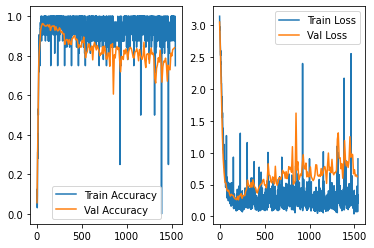

In [57]:
train(model, train_loader, val_loader, loss_func, optimizer, "model", start_frozen=False, model_unfreeze=0)

### 1.4 Implement Unfreezing (1 hr)

#### Description

Unfreezing is a technique that can be helpful when fine tuning a CNN for a more difficult task with a large amount of data.

The idea is that if we allow the network to tweak the earliest layers immediately, before the last FCL has been trained at all, the earliest layers will forget all of the useful features that they learned in order  to provide features that are helpful for the (untrained) FCL.

So, rather than training all of the model weights at once, we learn the last fully connected layer, then train that layer together with the second-to-last layer, gradually adding layers until we reach the first layer.

#### TODO:

- Modify your model class by setting the `requires_grad` attribute of the ResNet to `False`. (but keep `requires_grad = True` for the last layer).
- Add a member function to you model class that allows the user to unfreeze weights in the training loop. See [this github gist](https://gist.github.com/jcjohnson/6e41e8512c17eae5da50aebef3378a4c) for reference.
- Modify your training loop to add logic that calls the `unfreeze` function of the model class (unfreeze one layer every epoch).
- Call your train function to fine-tune the ResNet on your dataset.

#### Call your train function

In [54]:
freeze_model = ResNetDogs(num_classes, start_frozen=True).to(device)
freeze_loss_func = nn.CrossEntropyLoss()
freeze_optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-1)

20




  0%|          | 0/1540 [00:00<?, ?it/s]

train loss:3.0451, train accuracy:0.0625.:   0%|          | 0/1540 [00:12<?, ?it/s]

train loss:3.0451, train accuracy:0.0625.:   0%|          | 1/1540 [00:12<5:28:45, 12.82s/it]

train loss:2.9879, train accuracy:0.1250.:   0%|          | 1/1540 [00:13<5:28:45, 12.82s/it]

train loss:2.9879, train accuracy:0.1250.:   0%|          | 2/1540 [00:13<3:52:41,  9.08s/it]

train loss:2.9863, train accuracy:0.0625.:   0%|          | 2/1540 [00:13<3:52:41,  9.08s/it]

train loss:2.9863, train accuracy:0.0625.:   0%|          | 3/1540 [00:13<2:45:32,  6.46s/it]

train loss:3.0894, train accuracy:0.0000.:   0%|          | 3/1540 [00:13<2:45:32,  6.46s/it]

train loss:3.0894, train accuracy:0.0000.:   0%|          | 4/1540 [00:13<1:58:46,  4.64s/it]

train loss:3.0945, train accuracy:0.0938.:   0%|          | 4/1540 [00:14<1:58:46,  4.64s/it]

train loss:3.0945, train accuracy:0.0938.:   0%|          | 5/1540 [00:14<1:25:51,  3.36s/it]

train loss:3.131

Saving state for epoch 1




train loss:3.0996, train accuracy:0.0312.:   5%|▌         | 77/1540 [01:59<22:46,  1.07it/s]

train loss:3.0996, train accuracy:0.0312.:   5%|▌         | 78/1540 [01:59<22:50,  1.07it/s]

train loss:2.9963, train accuracy:0.0312.:   5%|▌         | 78/1540 [01:59<22:50,  1.07it/s]

train loss:2.9963, train accuracy:0.0312.:   5%|▌         | 79/1540 [01:59<18:34,  1.31it/s]

train loss:2.9730, train accuracy:0.1250.:   5%|▌         | 79/1540 [02:00<18:34,  1.31it/s]

train loss:2.9730, train accuracy:0.1250.:   5%|▌         | 80/1540 [02:00<15:42,  1.55it/s]

train loss:3.0593, train accuracy:0.0312.:   5%|▌         | 80/1540 [02:11<15:42,  1.55it/s]

train loss:3.0593, train accuracy:0.0312.:   5%|▌         | 81/1540 [02:11<1:34:26,  3.88s/it]

train loss:3.0537, train accuracy:0.0000.:   5%|▌         | 81/1540 [02:12<1:34:26,  3.88s/it]

train loss:3.0537, train accuracy:0.0000.:   5%|▌         | 82/1540 [02:12<1:08:39,  2.83s/it]

train loss:3.0483, train accuracy:0.0625.:   5%|▌   

Saving state for epoch 2




train loss:3.0367, train accuracy:0.0625.:  10%|█         | 154/1540 [03:57<46:55,  2.03s/it]

train loss:3.0367, train accuracy:0.0625.:  10%|█         | 155/1540 [03:57<39:33,  1.71s/it]

train loss:3.0411, train accuracy:0.0000.:  10%|█         | 155/1540 [03:57<39:33,  1.71s/it]

train loss:3.0411, train accuracy:0.0000.:  10%|█         | 156/1540 [03:57<30:07,  1.31s/it]

train loss:2.9907, train accuracy:0.0312.:  10%|█         | 156/1540 [03:58<30:07,  1.31s/it]

train loss:2.9907, train accuracy:0.0312.:  10%|█         | 157/1540 [03:58<23:29,  1.02s/it]

train loss:3.0216, train accuracy:0.0312.:  10%|█         | 157/1540 [03:58<23:29,  1.02s/it]

train loss:3.0216, train accuracy:0.0312.:  10%|█         | 158/1540 [03:58<18:57,  1.22it/s]

train loss:3.0815, train accuracy:0.0312.:  10%|█         | 158/1540 [03:58<18:57,  1.22it/s]

train loss:3.0815, train accuracy:0.0312.:  10%|█         | 159/1540 [03:58<15:36,  1.47it/s]

train loss:3.0961, train accuracy:0.0000.:  10%|

Saving state for epoch 3




train loss:3.0324, train accuracy:0.0000.:  15%|█▌        | 231/1540 [05:55<1:21:20,  3.73s/it]

train loss:3.0324, train accuracy:0.0000.:  15%|█▌        | 232/1540 [05:55<1:08:32,  3.14s/it]

train loss:2.9924, train accuracy:0.0000.:  15%|█▌        | 232/1540 [05:55<1:08:32,  3.14s/it]

train loss:2.9924, train accuracy:0.0000.:  15%|█▌        | 233/1540 [05:55<50:36,  2.32s/it]  

train loss:3.0962, train accuracy:0.0312.:  15%|█▌        | 233/1540 [05:55<50:36,  2.32s/it]

train loss:3.0962, train accuracy:0.0312.:  15%|█▌        | 234/1540 [05:55<37:39,  1.73s/it]

train loss:3.0437, train accuracy:0.0000.:  15%|█▌        | 234/1540 [05:56<37:39,  1.73s/it]

train loss:3.0437, train accuracy:0.0000.:  15%|█▌        | 235/1540 [05:56<28:47,  1.32s/it]

train loss:3.1721, train accuracy:0.0000.:  15%|█▌        | 235/1540 [05:56<28:47,  1.32s/it]

train loss:3.1721, train accuracy:0.0000.:  15%|█▌        | 236/1540 [05:56<22:23,  1.03s/it]

train loss:2.9627, train accuracy:0.0938

Saving state for epoch 4




train loss:3.0701, train accuracy:0.0000.:  20%|██        | 308/1540 [07:41<15:29,  1.32it/s]

train loss:3.0701, train accuracy:0.0000.:  20%|██        | 309/1540 [07:41<16:59,  1.21it/s]

train loss:3.0781, train accuracy:0.0000.:  20%|██        | 309/1540 [07:42<16:59,  1.21it/s]

train loss:3.0781, train accuracy:0.0000.:  20%|██        | 310/1540 [07:42<14:10,  1.45it/s]

train loss:3.0905, train accuracy:0.0000.:  20%|██        | 310/1540 [07:53<14:10,  1.45it/s]

train loss:3.0905, train accuracy:0.0000.:  20%|██        | 311/1540 [07:53<1:20:33,  3.93s/it]

train loss:2.9608, train accuracy:0.0312.:  20%|██        | 311/1540 [07:53<1:20:33,  3.93s/it]

train loss:2.9608, train accuracy:0.0312.:  20%|██        | 312/1540 [07:53<58:26,  2.86s/it]  

train loss:3.0188, train accuracy:0.0625.:  20%|██        | 312/1540 [07:54<58:26,  2.86s/it]

train loss:3.0188, train accuracy:0.0625.:  20%|██        | 313/1540 [07:54<43:00,  2.10s/it]

train loss:3.0443, train accuracy:0.0312.:

Saving state for epoch 5




train loss:3.0056, train accuracy:0.0312.:  25%|██▌       | 385/1540 [09:39<29:32,  1.53s/it]

train loss:3.0056, train accuracy:0.0312.:  25%|██▌       | 386/1540 [09:39<26:37,  1.38s/it]

train loss:3.0086, train accuracy:0.0938.:  25%|██▌       | 386/1540 [09:39<26:37,  1.38s/it]

train loss:3.0086, train accuracy:0.0938.:  25%|██▌       | 387/1540 [09:39<20:34,  1.07s/it]

train loss:3.0763, train accuracy:0.0000.:  25%|██▌       | 387/1540 [09:40<20:34,  1.07s/it]

train loss:3.0763, train accuracy:0.0000.:  25%|██▌       | 388/1540 [09:40<16:27,  1.17it/s]

train loss:3.0756, train accuracy:0.0625.:  25%|██▌       | 388/1540 [09:40<16:27,  1.17it/s]

train loss:3.0756, train accuracy:0.0625.:  25%|██▌       | 389/1540 [09:40<13:31,  1.42it/s]

train loss:3.1081, train accuracy:0.0312.:  25%|██▌       | 389/1540 [09:41<13:31,  1.42it/s]

train loss:3.1081, train accuracy:0.0312.:  25%|██▌       | 390/1540 [09:41<11:25,  1.68it/s]

train loss:3.0877, train accuracy:0.0312.:  25%|

Saving state for epoch 6




train loss:2.9558, train accuracy:0.0312.:  30%|███       | 462/1540 [11:36<1:07:45,  3.77s/it]

train loss:2.9558, train accuracy:0.0312.:  30%|███       | 463/1540 [11:36<52:03,  2.90s/it]  

train loss:3.1104, train accuracy:0.0312.:  30%|███       | 463/1540 [11:37<52:03,  2.90s/it]

train loss:3.1104, train accuracy:0.0312.:  30%|███       | 464/1540 [11:37<38:37,  2.15s/it]

train loss:3.0142, train accuracy:0.0000.:  30%|███       | 464/1540 [11:37<38:37,  2.15s/it]

train loss:3.0142, train accuracy:0.0000.:  30%|███       | 465/1540 [11:37<28:50,  1.61s/it]

train loss:3.1815, train accuracy:0.0312.:  30%|███       | 465/1540 [11:37<28:50,  1.61s/it]

train loss:3.1815, train accuracy:0.0312.:  30%|███       | 466/1540 [11:37<22:08,  1.24s/it]

train loss:3.0822, train accuracy:0.0312.:  30%|███       | 466/1540 [11:38<22:08,  1.24s/it]

train loss:3.0822, train accuracy:0.0312.:  30%|███       | 467/1540 [11:38<17:20,  1.03it/s]

train loss:3.0941, train accuracy:0.0312.:  

Saving state for epoch 7




train loss:3.0545, train accuracy:0.0000.:  35%|███▌      | 539/1540 [13:23<10:35,  1.57it/s]

train loss:3.0545, train accuracy:0.0000.:  35%|███▌      | 540/1540 [13:23<12:20,  1.35it/s]

train loss:3.0428, train accuracy:0.0625.:  35%|███▌      | 540/1540 [13:34<12:20,  1.35it/s]

train loss:3.0428, train accuracy:0.0625.:  35%|███▌      | 541/1540 [13:34<1:06:24,  3.99s/it]

train loss:2.9950, train accuracy:0.0312.:  35%|███▌      | 541/1540 [13:35<1:06:24,  3.99s/it]

train loss:2.9950, train accuracy:0.0312.:  35%|███▌      | 542/1540 [13:35<48:11,  2.90s/it]  

train loss:3.0082, train accuracy:0.1250.:  35%|███▌      | 542/1540 [13:35<48:11,  2.90s/it]

train loss:3.0082, train accuracy:0.1250.:  35%|███▌      | 543/1540 [13:35<35:23,  2.13s/it]

train loss:2.9915, train accuracy:0.1250.:  35%|███▌      | 543/1540 [13:35<35:23,  2.13s/it]

train loss:2.9915, train accuracy:0.1250.:  35%|███▌      | 544/1540 [13:35<26:35,  1.60s/it]

train loss:3.1311, train accuracy:0.0000.:

Saving state for epoch 8




train loss:3.0124, train accuracy:0.0938.:  40%|████      | 616/1540 [15:20<18:09,  1.18s/it]

train loss:3.0124, train accuracy:0.0938.:  40%|████      | 617/1540 [15:20<17:13,  1.12s/it]

train loss:3.0598, train accuracy:0.0312.:  40%|████      | 617/1540 [15:21<17:13,  1.12s/it]

train loss:3.0598, train accuracy:0.0312.:  40%|████      | 618/1540 [15:21<13:38,  1.13it/s]

train loss:3.0557, train accuracy:0.0000.:  40%|████      | 618/1540 [15:21<13:38,  1.13it/s]

train loss:3.0557, train accuracy:0.0000.:  40%|████      | 619/1540 [15:21<11:11,  1.37it/s]

train loss:3.1250, train accuracy:0.0312.:  40%|████      | 619/1540 [15:21<11:11,  1.37it/s]

train loss:3.1250, train accuracy:0.0312.:  40%|████      | 620/1540 [15:21<09:27,  1.62it/s]

train loss:3.0542, train accuracy:0.0000.:  40%|████      | 620/1540 [15:33<09:27,  1.62it/s]

train loss:3.0542, train accuracy:0.0000.:  40%|████      | 621/1540 [15:33<59:27,  3.88s/it]

train loss:2.9955, train accuracy:0.0625.:  40%|

Saving state for epoch 9




train loss:3.0890, train accuracy:0.0312.:  45%|████▌     | 693/1540 [17:18<38:40,  2.74s/it]

train loss:3.0890, train accuracy:0.0312.:  45%|████▌     | 694/1540 [17:18<31:15,  2.22s/it]

train loss:2.9827, train accuracy:0.0625.:  45%|████▌     | 694/1540 [17:18<31:15,  2.22s/it]

train loss:2.9827, train accuracy:0.0625.:  45%|████▌     | 695/1540 [17:18<23:22,  1.66s/it]

train loss:3.0694, train accuracy:0.0312.:  45%|████▌     | 695/1540 [17:19<23:22,  1.66s/it]

train loss:3.0694, train accuracy:0.0312.:  45%|████▌     | 696/1540 [17:19<17:47,  1.26s/it]

train loss:2.9432, train accuracy:0.0312.:  45%|████▌     | 696/1540 [17:19<17:47,  1.26s/it]

train loss:2.9432, train accuracy:0.0312.:  45%|████▌     | 697/1540 [17:19<13:57,  1.01it/s]

train loss:3.0304, train accuracy:0.0312.:  45%|████▌     | 697/1540 [17:19<13:57,  1.01it/s]

train loss:3.0304, train accuracy:0.0312.:  45%|████▌     | 698/1540 [17:19<11:13,  1.25it/s]

train loss:2.9946, train accuracy:0.0312.:  45%|

Saving state for epoch 10




train loss:3.0565, train accuracy:0.0625.:  50%|█████     | 770/1540 [19:16<07:02,  1.82it/s]

train loss:3.0565, train accuracy:0.0625.:  50%|█████     | 771/1540 [19:16<30:20,  2.37s/it]

train loss:3.0073, train accuracy:0.1250.:  50%|█████     | 771/1540 [19:16<30:20,  2.37s/it]

train loss:3.0073, train accuracy:0.1250.:  50%|█████     | 772/1540 [19:16<22:31,  1.76s/it]

train loss:3.0320, train accuracy:0.0312.:  50%|█████     | 772/1540 [19:17<22:31,  1.76s/it]

train loss:3.0320, train accuracy:0.0312.:  50%|█████     | 773/1540 [19:17<17:01,  1.33s/it]

train loss:3.1601, train accuracy:0.0312.:  50%|█████     | 773/1540 [19:17<17:01,  1.33s/it]

train loss:3.1601, train accuracy:0.0312.:  50%|█████     | 774/1540 [19:17<13:21,  1.05s/it]

train loss:3.0790, train accuracy:0.0000.:  50%|█████     | 774/1540 [19:17<13:21,  1.05s/it]

train loss:3.0790, train accuracy:0.0000.:  50%|█████     | 775/1540 [19:17<10:37,  1.20it/s]

train loss:3.0500, train accuracy:0.0312.:  50%|

Saving state for epoch 11




train loss:3.0132, train accuracy:0.0625.:  55%|█████▌    | 847/1540 [21:03<10:40,  1.08it/s]

train loss:3.0132, train accuracy:0.0625.:  55%|█████▌    | 848/1540 [21:03<10:33,  1.09it/s]

train loss:3.0667, train accuracy:0.0000.:  55%|█████▌    | 848/1540 [21:03<10:33,  1.09it/s]

train loss:3.0667, train accuracy:0.0000.:  55%|█████▌    | 849/1540 [21:03<08:44,  1.32it/s]

train loss:3.0378, train accuracy:0.0312.:  55%|█████▌    | 849/1540 [21:03<08:44,  1.32it/s]

train loss:3.0378, train accuracy:0.0312.:  55%|█████▌    | 850/1540 [21:03<07:18,  1.57it/s]

train loss:3.1019, train accuracy:0.0625.:  55%|█████▌    | 850/1540 [21:15<07:18,  1.57it/s]

train loss:3.1019, train accuracy:0.0625.:  55%|█████▌    | 851/1540 [21:15<45:13,  3.94s/it]

train loss:3.0555, train accuracy:0.0625.:  55%|█████▌    | 851/1540 [21:15<45:13,  3.94s/it]

train loss:3.0555, train accuracy:0.0625.:  55%|█████▌    | 852/1540 [21:15<32:47,  2.86s/it]

train loss:3.1654, train accuracy:0.0312.:  55%|

Saving state for epoch 12




train loss:3.0271, train accuracy:0.0625.:  60%|██████    | 924/1540 [23:00<20:46,  2.02s/it]

train loss:3.0271, train accuracy:0.0625.:  60%|██████    | 925/1540 [23:00<17:15,  1.68s/it]

train loss:3.0214, train accuracy:0.0625.:  60%|██████    | 925/1540 [23:00<17:15,  1.68s/it]

train loss:3.0214, train accuracy:0.0625.:  60%|██████    | 926/1540 [23:00<13:20,  1.30s/it]

train loss:3.1392, train accuracy:0.0625.:  60%|██████    | 926/1540 [23:00<13:20,  1.30s/it]

train loss:3.1392, train accuracy:0.0625.:  60%|██████    | 927/1540 [23:00<10:22,  1.02s/it]

train loss:3.1239, train accuracy:0.0625.:  60%|██████    | 927/1540 [23:01<10:22,  1.02s/it]

train loss:3.1239, train accuracy:0.0625.:  60%|██████    | 928/1540 [23:01<08:22,  1.22it/s]

train loss:3.0284, train accuracy:0.0312.:  60%|██████    | 928/1540 [23:01<08:22,  1.22it/s]

train loss:3.0284, train accuracy:0.0312.:  60%|██████    | 929/1540 [23:01<06:54,  1.47it/s]

train loss:3.1227, train accuracy:0.0000.:  60%|

Saving state for epoch 13




train loss:3.0907, train accuracy:0.0000.:  65%|██████▌   | 1001/1540 [24:58<33:36,  3.74s/it]

train loss:3.0907, train accuracy:0.0000.:  65%|██████▌   | 1002/1540 [24:58<28:37,  3.19s/it]

train loss:3.0853, train accuracy:0.0625.:  65%|██████▌   | 1002/1540 [24:58<28:37,  3.19s/it]

train loss:3.0853, train accuracy:0.0625.:  65%|██████▌   | 1003/1540 [24:58<20:54,  2.34s/it]

train loss:3.0672, train accuracy:0.0625.:  65%|██████▌   | 1003/1540 [24:58<20:54,  2.34s/it]

train loss:3.0672, train accuracy:0.0625.:  65%|██████▌   | 1004/1540 [24:58<15:34,  1.74s/it]

train loss:3.0004, train accuracy:0.0000.:  65%|██████▌   | 1004/1540 [24:59<15:34,  1.74s/it]

train loss:3.0004, train accuracy:0.0000.:  65%|██████▌   | 1005/1540 [24:59<11:50,  1.33s/it]

train loss:3.0457, train accuracy:0.0000.:  65%|██████▌   | 1005/1540 [24:59<11:50,  1.33s/it]

train loss:3.0457, train accuracy:0.0000.:  65%|██████▌   | 1006/1540 [24:59<09:11,  1.03s/it]

train loss:3.1188, train accuracy:0.06

Saving state for epoch 14




train loss:3.0348, train accuracy:0.0312.:  70%|███████   | 1078/1540 [26:44<05:47,  1.33it/s]

train loss:3.0348, train accuracy:0.0312.:  70%|███████   | 1079/1540 [26:44<06:09,  1.25it/s]

train loss:3.0543, train accuracy:0.0312.:  70%|███████   | 1079/1540 [26:44<06:09,  1.25it/s]

train loss:3.0543, train accuracy:0.0312.:  70%|███████   | 1080/1540 [26:44<05:11,  1.48it/s]

train loss:3.0006, train accuracy:0.0312.:  70%|███████   | 1080/1540 [26:56<05:11,  1.48it/s]

train loss:3.0006, train accuracy:0.0312.:  70%|███████   | 1081/1540 [26:56<29:53,  3.91s/it]

train loss:2.9796, train accuracy:0.0625.:  70%|███████   | 1081/1540 [26:56<29:53,  3.91s/it]

train loss:2.9796, train accuracy:0.0625.:  70%|███████   | 1082/1540 [26:56<21:39,  2.84s/it]

train loss:3.0025, train accuracy:0.0938.:  70%|███████   | 1082/1540 [26:56<21:39,  2.84s/it]

train loss:3.0025, train accuracy:0.0938.:  70%|███████   | 1083/1540 [26:56<15:53,  2.09s/it]

train loss:3.0278, train accuracy:0.00

Saving state for epoch 15




train loss:3.1547, train accuracy:0.0000.:  75%|███████▌  | 1155/1540 [28:41<09:48,  1.53s/it]

train loss:3.1547, train accuracy:0.0000.:  75%|███████▌  | 1156/1540 [28:41<08:38,  1.35s/it]

train loss:3.0954, train accuracy:0.0625.:  75%|███████▌  | 1156/1540 [28:42<08:38,  1.35s/it]

train loss:3.0954, train accuracy:0.0625.:  75%|███████▌  | 1157/1540 [28:42<06:46,  1.06s/it]

train loss:3.1151, train accuracy:0.0312.:  75%|███████▌  | 1157/1540 [28:42<06:46,  1.06s/it]

train loss:3.1151, train accuracy:0.0312.:  75%|███████▌  | 1158/1540 [28:42<05:22,  1.18it/s]

train loss:3.0530, train accuracy:0.0625.:  75%|███████▌  | 1158/1540 [28:42<05:22,  1.18it/s]

train loss:3.0530, train accuracy:0.0625.:  75%|███████▌  | 1159/1540 [28:42<04:26,  1.43it/s]

train loss:3.0509, train accuracy:0.0938.:  75%|███████▌  | 1159/1540 [28:43<04:26,  1.43it/s]

train loss:3.0509, train accuracy:0.0938.:  75%|███████▌  | 1160/1540 [28:43<03:45,  1.69it/s]

train loss:3.0458, train accuracy:0.06

Saving state for epoch 16




train loss:3.0621, train accuracy:0.0312.:  80%|████████  | 1232/1540 [30:38<19:18,  3.76s/it]

train loss:3.0621, train accuracy:0.0312.:  80%|████████  | 1233/1540 [30:38<15:00,  2.93s/it]

train loss:3.1544, train accuracy:0.0312.:  80%|████████  | 1233/1540 [30:39<15:00,  2.93s/it]

train loss:3.1544, train accuracy:0.0312.:  80%|████████  | 1234/1540 [30:39<10:59,  2.16s/it]

train loss:2.9858, train accuracy:0.0625.:  80%|████████  | 1234/1540 [30:39<10:59,  2.16s/it]

train loss:2.9858, train accuracy:0.0625.:  80%|████████  | 1235/1540 [30:39<08:12,  1.61s/it]

train loss:3.0422, train accuracy:0.0625.:  80%|████████  | 1235/1540 [30:39<08:12,  1.61s/it]

train loss:3.0422, train accuracy:0.0625.:  80%|████████  | 1236/1540 [30:39<06:16,  1.24s/it]

train loss:3.0565, train accuracy:0.0625.:  80%|████████  | 1236/1540 [30:40<06:16,  1.24s/it]

train loss:3.0565, train accuracy:0.0625.:  80%|████████  | 1237/1540 [30:40<04:53,  1.03it/s]

train loss:3.0970, train accuracy:0.00

Saving state for epoch 17




train loss:3.1018, train accuracy:0.0312.:  85%|████████▌ | 1309/1540 [32:24<02:25,  1.58it/s]

train loss:3.1018, train accuracy:0.0312.:  85%|████████▌ | 1310/1540 [32:24<02:45,  1.39it/s]

train loss:3.0347, train accuracy:0.0625.:  85%|████████▌ | 1310/1540 [32:36<02:45,  1.39it/s]

train loss:3.0347, train accuracy:0.0625.:  85%|████████▌ | 1311/1540 [32:36<15:02,  3.94s/it]

train loss:2.9735, train accuracy:0.0625.:  85%|████████▌ | 1311/1540 [32:36<15:02,  3.94s/it]

train loss:2.9735, train accuracy:0.0625.:  85%|████████▌ | 1312/1540 [32:36<10:52,  2.86s/it]

train loss:3.0565, train accuracy:0.0000.:  85%|████████▌ | 1312/1540 [32:37<10:52,  2.86s/it]

train loss:3.0565, train accuracy:0.0000.:  85%|████████▌ | 1313/1540 [32:37<07:57,  2.10s/it]

train loss:3.1456, train accuracy:0.0312.:  85%|████████▌ | 1313/1540 [32:37<07:57,  2.10s/it]

train loss:3.1456, train accuracy:0.0312.:  85%|████████▌ | 1314/1540 [32:37<05:57,  1.58s/it]

train loss:3.0488, train accuracy:0.06

Saving state for epoch 18




train loss:3.0444, train accuracy:0.0625.:  90%|█████████ | 1386/1540 [34:22<03:00,  1.17s/it]

train loss:3.0444, train accuracy:0.0625.:  90%|█████████ | 1387/1540 [34:22<02:51,  1.12s/it]

train loss:3.0571, train accuracy:0.0000.:  90%|█████████ | 1387/1540 [34:22<02:51,  1.12s/it]

train loss:3.0571, train accuracy:0.0000.:  90%|█████████ | 1388/1540 [34:22<02:14,  1.13it/s]

train loss:3.0077, train accuracy:0.0625.:  90%|█████████ | 1388/1540 [34:23<02:14,  1.13it/s]

train loss:3.0077, train accuracy:0.0625.:  90%|█████████ | 1389/1540 [34:23<01:50,  1.37it/s]

train loss:3.0382, train accuracy:0.1250.:  90%|█████████ | 1389/1540 [34:23<01:50,  1.37it/s]

train loss:3.0382, train accuracy:0.1250.:  90%|█████████ | 1390/1540 [34:23<01:32,  1.63it/s]

train loss:3.0293, train accuracy:0.0000.:  90%|█████████ | 1390/1540 [34:35<01:32,  1.63it/s]

train loss:3.0293, train accuracy:0.0000.:  90%|█████████ | 1391/1540 [34:35<09:41,  3.90s/it]

train loss:2.9905, train accuracy:0.00

Saving state for epoch 19




train loss:3.1007, train accuracy:0.0312.:  95%|█████████▌| 1463/1540 [36:19<03:32,  2.76s/it]

train loss:3.1007, train accuracy:0.0312.:  95%|█████████▌| 1464/1540 [36:19<02:48,  2.21s/it]

train loss:3.0681, train accuracy:0.0000.:  95%|█████████▌| 1464/1540 [36:20<02:48,  2.21s/it]

train loss:3.0681, train accuracy:0.0000.:  95%|█████████▌| 1465/1540 [36:20<02:05,  1.68s/it]

train loss:3.0307, train accuracy:0.0000.:  95%|█████████▌| 1465/1540 [36:20<02:05,  1.68s/it]

train loss:3.0307, train accuracy:0.0000.:  95%|█████████▌| 1466/1540 [36:20<01:34,  1.28s/it]

train loss:3.0685, train accuracy:0.0938.:  95%|█████████▌| 1466/1540 [36:21<01:34,  1.28s/it]

train loss:3.0685, train accuracy:0.0938.:  95%|█████████▌| 1467/1540 [36:21<01:13,  1.00s/it]

train loss:3.0540, train accuracy:0.1562.:  95%|█████████▌| 1467/1540 [36:21<01:13,  1.00s/it]

train loss:3.0540, train accuracy:0.1562.:  95%|█████████▌| 1468/1540 [36:21<00:58,  1.24it/s]

train loss:3.0856, train accuracy:0.03

Saving state for epoch 20


train loss:2.9539, train accuracy:0.2500.: 100%|██████████| 1540/1540 [38:05<00:00,  1.48s/it]


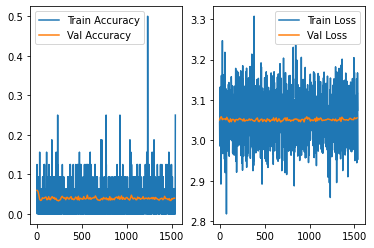

In [55]:
############################
# train with unfreezing here (should be a single call to your train function)
############################
train(freeze_model, train_loader, val_loader, freeze_loss_func, freeze_optimizer, "freeze_model", start_frozen=True, model_unfreeze=5)

You may not see any improvement for your classification task, but unfreezing can help convergence for more difficult image classification tasks.

##2 Fine-tune a language model - (15 min)

In this section you will use the gpt-2-simple package [here](https://github.com/minimaxir/gpt-2-simple) to fine-tune the GPT-2 language model on a domain of your choice.

### 2.1 Generate text from an the pretrained GPT-2 model

#### Run this code to generate text from a pretrained model

In [ ]:
# !pip install gpt-2-simple

In [3]:
# the transformers package is built on top of Tensorflow, and the default TF version 
# for Colab will soon switch to 2.x. We remedy this with the following magic method
%tensorflow_version 1.x 

import gpt_2_simple as gpt2
import os
import tensorflow as tf

TensorFlow 1.x selected.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [4]:
# This line is necessary to be able to run a new tf session
tf.reset_default_graph()
# The medium-sized model. IF you run out of memory, try "124M" instead
model_name = "124M"
if not os.path.isdir(os.path.join("models", model_name)):
	print(f"Downloading {model_name} model...")
	gpt2.download_gpt2(model_name=model_name)   # model is saved into current directory under /models/124M/

sess = gpt2.start_tf_sess()
gpt2.load_gpt2(sess, model_name=model_name)
gpt2.generate(sess, model_name=model_name)

Fetching checkpoint: 1.05Mit [00:00, 252Mit/s]                                                      
Fetching encoder.json: 1.05Mit [00:00, 87.8Mit/s]                                                   
Fetching hparams.json: 1.05Mit [00:00, 465Mit/s]                                                    
Fetching model.ckpt.data-00000-of-00001:   0%|                          | 0.00/498M [00:00<?, ?it/s]

Fetching model.ckpt.data-00000-of-00001: 498Mit [00:03, 144Mit/s]                                   
Fetching model.ckpt.index: 1.05Mit [00:00, 285Mit/s]                                                
Fetching model.ckpt.meta: 1.05Mit [00:00, 192Mit/s]                                                 
Fetching vocab.bpe: 1.05Mit [00:00, 189Mit/s]                                                       


Loading pretrained model models/124M/model.ckpt
INFO:tensorflow:Restoring parameters from models/124M/model.ckpt
Home > Education > Science > Science Technology > Technology and Design > Technology and Design > Technology and Design > Technology and Design > Technology and Design > Technology and Design > Technology and Design > Technology and Design > Technology and Design > Technology and Design > Technology and Design > Technology and Design > Technology and Design > Technology and Design > Technology and Design > Technology and Design > Technology and Design > Technology and Design > Technology and Design > Technology and Design > Technology and Design > Technology and Design > Technology and Design > Technology and Design > Technology and Design > Technology and Design > Technology and Design > Technology and Design > Technology and Design > Technology and Design > Technology and Design > Technology and Design > Technology and Design > Technology and Design > Technology and Design

### 2.2 Download a text dataset

#### TODO:

- Use the provided functions to download your own text dataset
- [Project Gutenberg](https://www.gutenberg.org/) is a nice starting point for raw text corpora

#### Download Dataset

In [6]:
import zipfile
import os
from torchvision import datasets
import subprocess

def extract_zip(zip_path, remove_finished=True):
    print('Extracting {}'.format(zip_path))
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(zip_path.replace('.zip', ''))
    if remove_finished:
        os.remove(zip_path)

def download_dataset(url, file_name, root='/data/text'):
    print(f'Downloading {url} to {root}/{file_name}')
    if not os.path.exists(os.path.join(root)):
        os.makedirs(os.path.join(root))

    datasets.utils.download_url(url, root, filename=file_name)
    extract_zip(os.path.join(root, file_name))
    return os.path.join(root)

##########################################
# Set the url for your dataset here,
# move the dataset to the desired location
##########################################

# Arthur Conan Doyle Sherlock Holmes works
# 1661/1661-0.zip = adventures of sherlock
# 2852/2852-0.zip = hound of baskervilles
# 244/244-0.zip = study in scarlet
# 108/108-0.zip = return of sherlock
# 834/834-0.zip = memoirs of sherlock
# 3289/3289-0.zip = the valley of fear
# 2349/2349.zip = adventure of devils foot
# 2347/2347.zip = adventures of dying detective
# 2350/2350-0.zip = epilogue of sherlock
# 2348/2348.zip = disappearance of lady frances
# 2345/2345.zip = adventure of red circle
# 2343/2343.zip = adventure of wysteria lodge
# 2344/2344.zip = adventure of cardboard box
# 2346/2346.zip = adventure of bruce-partington plans

url_base = 'https://www.gutenberg.org/files/'
book_urls = {
    'adven_sherlock': '1661/1661-0.zip',
    'hound_baskervilles': '2852/2852-0.zip',
    'study_scarlet': '244/244-0.zip',
    'return_sherlock': '108/108-0.zip',
    'memoirs_sherlock': '834/834-0.zip',
    'valley_fear': '3289/3289-0.zip',
    'devils_foot': '2349/2349.zip',
    'adven_dying_detective': '2347/2347.zip',
    'epilogue_sherlock': '2350/2350-0.zip',
    'lady_frances': '2348/2348.zip',
    'red_circle': '2345/2345.zip',
    'wysteria_lodge': '2343/2343.zip',
    'cardboard_box': '2344/2344.zip',
    'bruce_partington_plans': '2346/2346.zip',
}
for k, v in book_urls.items():
    file_path = os.path.join(v)
    download_dataset(url_base + v, os.path.basename(file_path))

Extracting /data/text/1661-0.zip


Extracting /data/text/2852-0.zip


Extracting /data/text/244-0.zip


Extracting /data/text/108-0.zip





Extracting /data/text/834-0.zip


Extracting /data/text/3289-0.zip


Extracting /data/text/2349.zip


Extracting /data/text/2347.zip





Extracting /data/text/2350-0.zip


Extracting /data/text/2348.zip


Extracting /data/text/2345.zip


Extracting /data/text/2343.zip


Extracting /data/text/2344.zip






Extracting /data/text/2346.zip


In [7]:
for k, v in book_urls.items():
    file_path = os.path.join(v)
    print(f'Moving /data/text/{file_path.split(".")[0]}.txt to /data/text/{k}.txt')
    subprocess.run(['mv', f'/data/text/{file_path.split(".")[0]}.txt', f'/data/text/{k}.txt'])
    ! ls ../data/text

Moving /data/text/1661/1661-0.txt to /data/text/adven_sherlock.txt
108   1661-0  2344  2346  2348	2350  244-0  2852-0  834
1661  2343    2345  2347  2349	244   2852   3289
Moving /data/text/2852/2852-0.txt to /data/text/hound_baskervilles.txt
108   1661-0  2344  2346  2348	2350  244-0  2852-0  834
1661  2343    2345  2347  2349	244   2852   3289
Moving /data/text/244/244-0.txt to /data/text/study_scarlet.txt
108   1661-0  2344  2346  2348	2350  244-0  2852-0  834
1661  2343    2345  2347  2349	244   2852   3289
Moving /data/text/108/108-0.txt to /data/text/return_sherlock.txt
108   1661-0  2344  2346  2348	2350  244-0  2852-0  834
1661  2343    2345  2347  2349	244   2852   3289    return_sherlock.txt
Moving /data/text/834/834-0.txt to /data/text/memoirs_sherlock.txt
108	2343  2346  2349  244-0   3289			return_sherlock.txt
1661	2344  2347  2350  2852	  834
1661-0	2345  2348  244   2852-0  memoirs_sherlock.txt
Moving /data/text/3289/3289-0.txt to /data/text/valley_fear.txt
108	2343  234

In [8]:
root = '/data/text'
all_text = os.path.join(root, 'all_text.txt')
for item in os.listdir(root):
    f_path = os.path.join(root, item)
    if os.path.isfile(f_path):
        lines = []
        with open(f_path, 'r') as f:
            lines = f.readlines()
        with open(all_text, 'a') as new_f:
            new_f.writelines(lines)

wysteria_lodge.txt
1661-0
epilogue_sherlock.txt
return_sherlock.txt
red_circle.txt
.ipynb_checkpoints
2344
2350
lady_frances.txt
cardboard_box.txt
bruce_partington_plans.txt
244-0
2348
2347
2349
3289
2346
devils_foot.txt
memoirs_sherlock.txt
valley_fear.txt
2852-0
108
2345
adven_dying_detective.txt
834
2343


### 2.3 Fine-tune GPT-2 on your own dataset

#### TODO:

- Swap out the dataset parameter with the path to your dataset

#### Train on your dataset

In [9]:
# This line is necessary to be able to run a new tf session if one has already been run
tf.reset_default_graph()
# Start a session
sess = gpt2.start_tf_sess()
# Fine tune `model_name` on `data`
###################################
# Swap out the `dataset` parameter with the path to your text dataset
###################################
gpt2.finetune(sess,
              dataset=all_text,
              model_name=model_name,
              restore_from='latest',
              steps=500)   # steps is max number of training steps

gpt2.generate(sess, run_name='run1')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Loading checkpoint models/124M/model.ckpt
INFO:tensorflow:Restoring parameters from models/124M/model.ckpt




  0%|          | 0/1 [00:00<?, ?it/s]

Loading dataset...




100%|██████████| 1/1 [00:03<00:00,  3.08s/it]


dataset has 709253 tokens
Training...
[1 | 7.25] loss=3.16 avg=3.16
[2 | 9.53] loss=3.01 avg=3.08
[3 | 11.81] loss=2.83 avg=3.00
[4 | 14.10] loss=3.03 avg=3.01
[5 | 16.40] loss=2.62 avg=2.93
[6 | 18.71] loss=2.53 avg=2.86
[7 | 21.02] loss=2.72 avg=2.84
[8 | 23.35] loss=2.31 avg=2.77
[9 | 25.69] loss=2.40 avg=2.73
[10 | 28.04] loss=2.90 avg=2.75
[11 | 30.40] loss=2.66 avg=2.74
[12 | 32.77] loss=2.66 avg=2.73
[13 | 35.15] loss=2.71 avg=2.73
[14 | 37.53] loss=3.03 avg=2.75
[15 | 39.92] loss=2.24 avg=2.72
[16 | 42.30] loss=2.19 avg=2.68
[17 | 44.67] loss=2.63 avg=2.68
[18 | 47.02] loss=2.63 avg=2.67
[19 | 49.36] loss=2.67 avg=2.67
[20 | 51.70] loss=2.67 avg=2.67
[21 | 54.03] loss=2.90 avg=2.69
[22 | 56.35] loss=2.86 avg=2.69
[23 | 58.67] loss=2.39 avg=2.68
[24 | 60.99] loss=2.21 avg=2.66
[25 | 63.29] loss=2.71 avg=2.66
[26 | 65.59] loss=2.64 avg=2.66
[27 | 67.88] loss=2.10 avg=2.64
[28 | 70.19] loss=1.94 avg=2.61
[29 | 72.48] loss=2.94 avg=2.62
[30 | 74.77] loss=2.34 avg=2.61
[31 | 77.06] 